In [3]:
import csv

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

In [4]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixed size for resizing
fixed_size = (256, 256)

# Preprocessing
def preprocess(image, target):
    transforms = Compose([
        Resize(fixed_size),
        ToTensor(),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    image = transforms(image)
    target = torch.as_tensor(np.array(target.resize(fixed_size, resample=0)), dtype=torch.long)
    return image, target

# Calculate mIoU for classes in ground truth
def calculate_miou(pred, target, num_classes=21):
    pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
    target = target.squeeze(0).cpu().numpy()
    unique_classes = np.unique(target)
    ious = []

    for cls in unique_classes:
        if cls == 255:  # Ignore 'void' class
            continue
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()

        if union == 0:
            ious.append(float('nan'))  # Skip classes with no ground truth
        else:
            ious.append(intersection / union)

    return np.nanmean(ious), {cls: iou for cls, iou in zip(unique_classes, ious) if cls != 255}

# Function to visualize and analyze specific indices
def visualize_and_analyze(indices, visualize=True):
    for idx in indices:
        image, target = val_dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        target = target.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_input)

        miou, class_wise_ious = calculate_miou(output, target, num_classes)

        # If visualizations are disabled, skip plotting
        if not visualize:
            print(f"Index: {idx}, mIoU: {miou:.4f}")
            continue

        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        target_np = target.squeeze(0).cpu().numpy()

        # Denormalize image
        image_np = image.permute(1, 2, 0).numpy()
        image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        image_np = np.clip(image_np, 0, 1)

        # Plot results
        plt.figure(figsize=(16, 8))
        plt.subplot(2, 2, 1)
        plt.imshow(image_np)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(2, 2, 2)
        plt.imshow(target_np, cmap="tab20")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(2, 2, 3)
        plt.imshow(pred, cmap="tab20")
        plt.title("Prediction")
        plt.axis("off")

        plt.subplot(2, 2, 4)
        bars = plt.bar(class_wise_ious.keys(), class_wise_ious.values(),
                       tick_label=[f"Class {cls}" for cls in class_wise_ious.keys()])
        plt.ylim(0, 1)
        plt.title(f"Class-wise IoU (mIoU: {miou:.4f})")
        plt.xlabel("Class")
        plt.ylabel("IoU")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        print(f"Index: {idx}, mIoU: {miou:.4f}")

# Function to calculate mIoU for all images and save to CSV
def calculate_all_mious(csv_path="miou_all_samples.csv"):
    all_mious = []

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Index", "Average mIoU"])

        for idx in range(len(val_dataset)):
            image, target = val_dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            target = target.unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(image_input)

            miou, _ = calculate_miou(output, target, num_classes)
            all_mious.append(miou)
            writer.writerow([idx, miou])

    avg_miou = np.nanmean(all_mious)
    print(f"Overall Average mIoU: {avg_miou:.4f}")

In [5]:
# Load PASCAL VOC 2012 dataset
val_dataset = VOCSegmentation(
    root="./data",
    year="2012",
    image_set="val",
    download=True,
    transforms=preprocess
)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


C:\Users\David Hoernke\AppData\Local\Temp\ipykernel_26108\3103263937.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./KnowledgeDistill

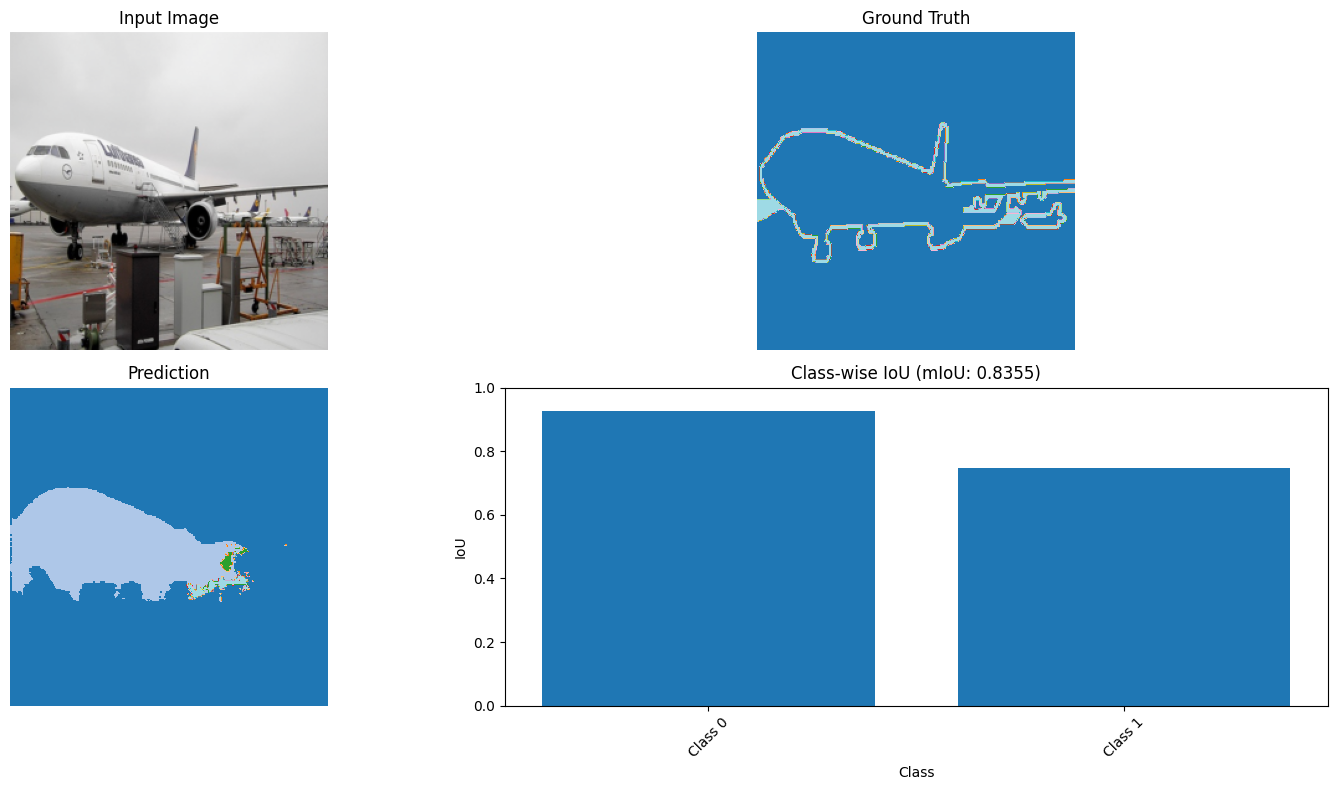

Index: 0, mIoU: 0.8355


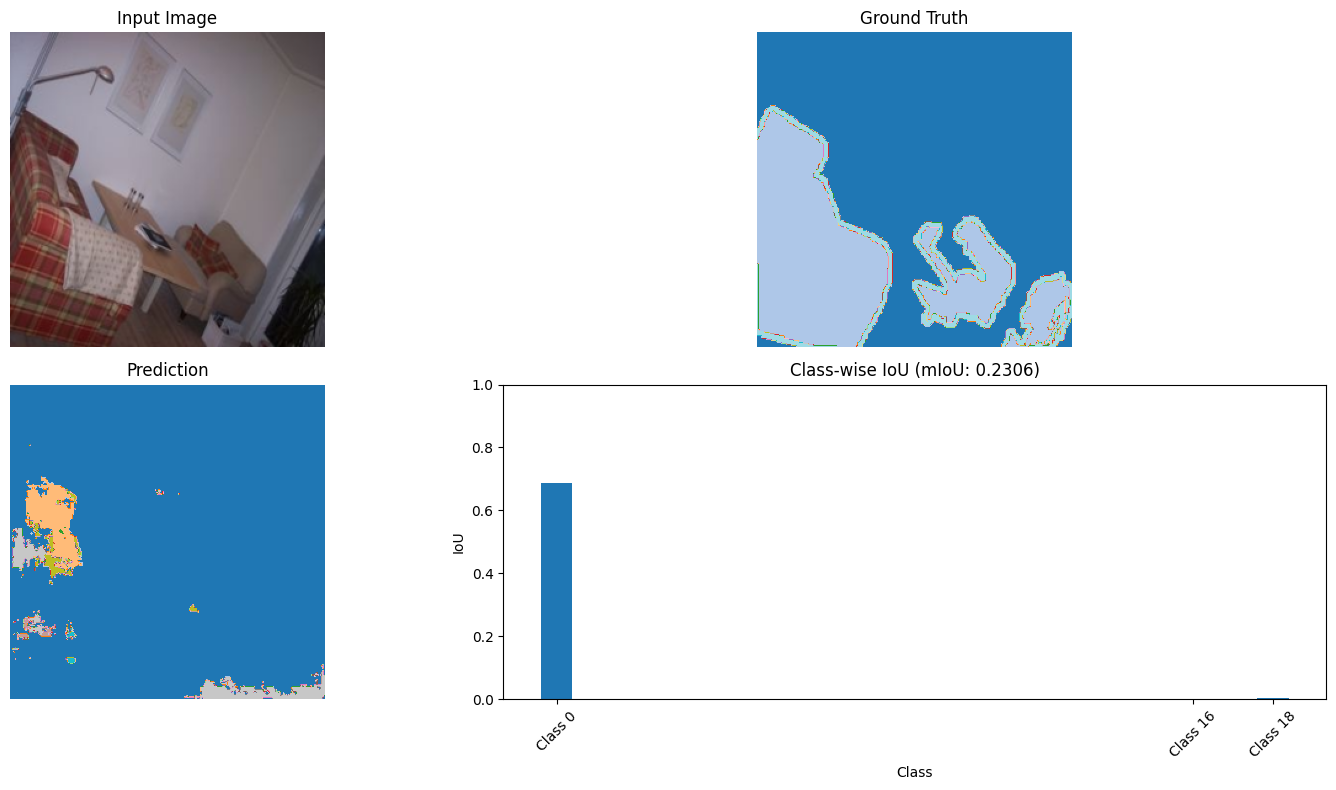

Index: 77, mIoU: 0.2306


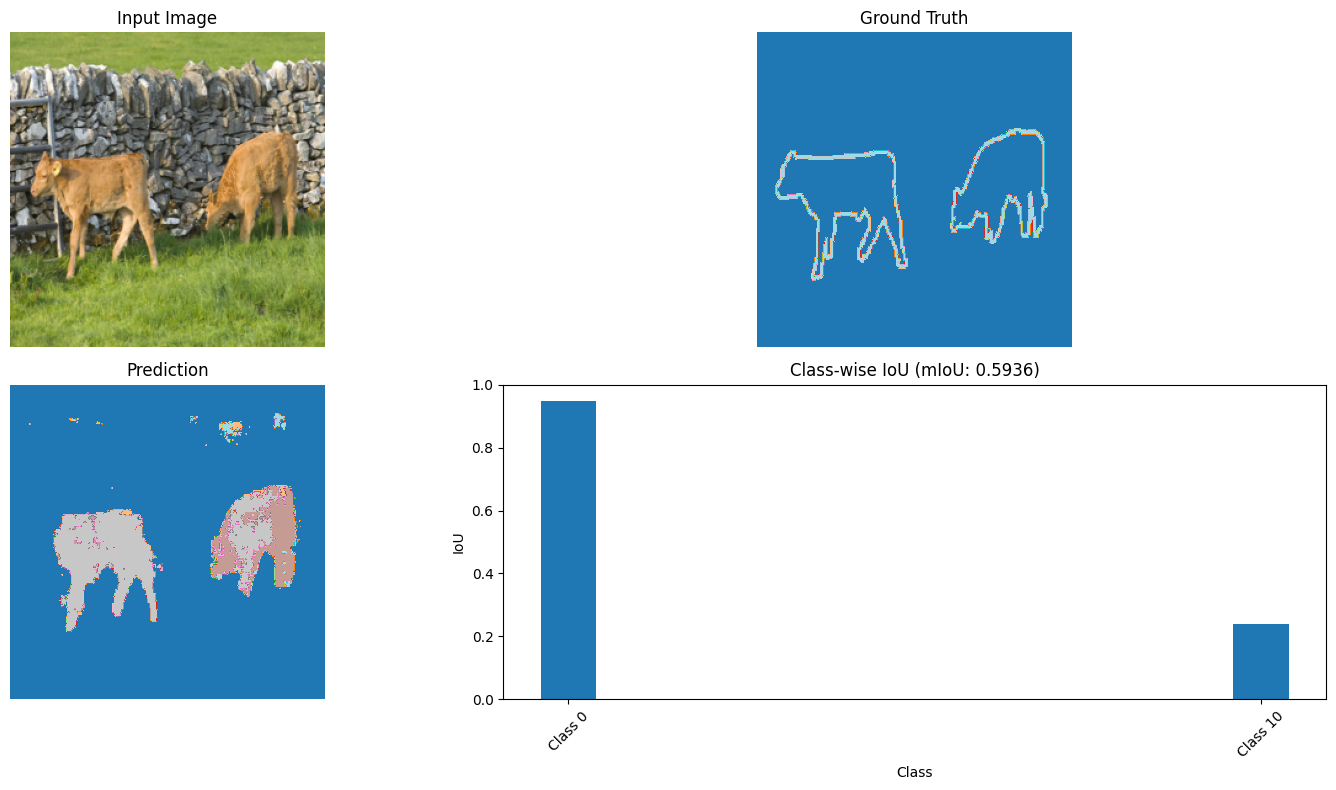

Index: 777, mIoU: 0.5936


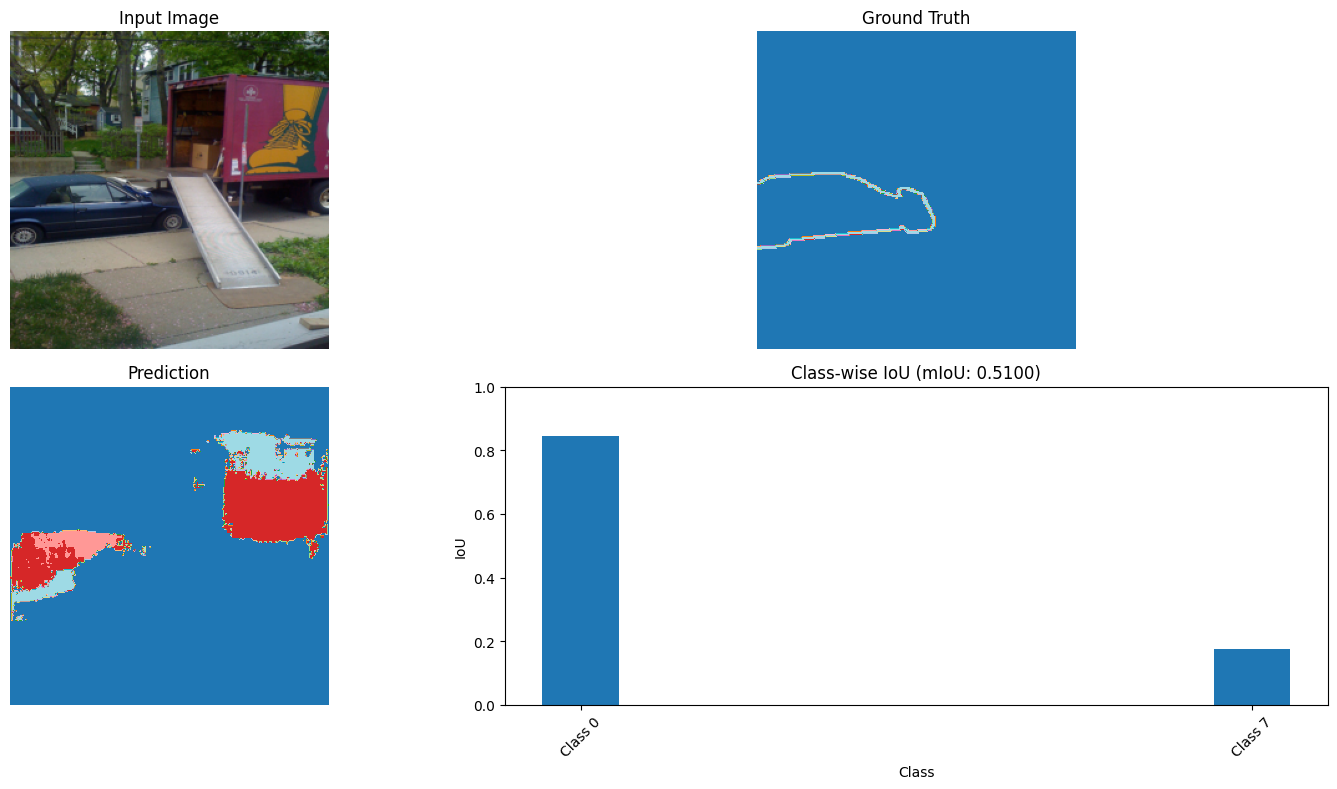

Index: 707, mIoU: 0.5100


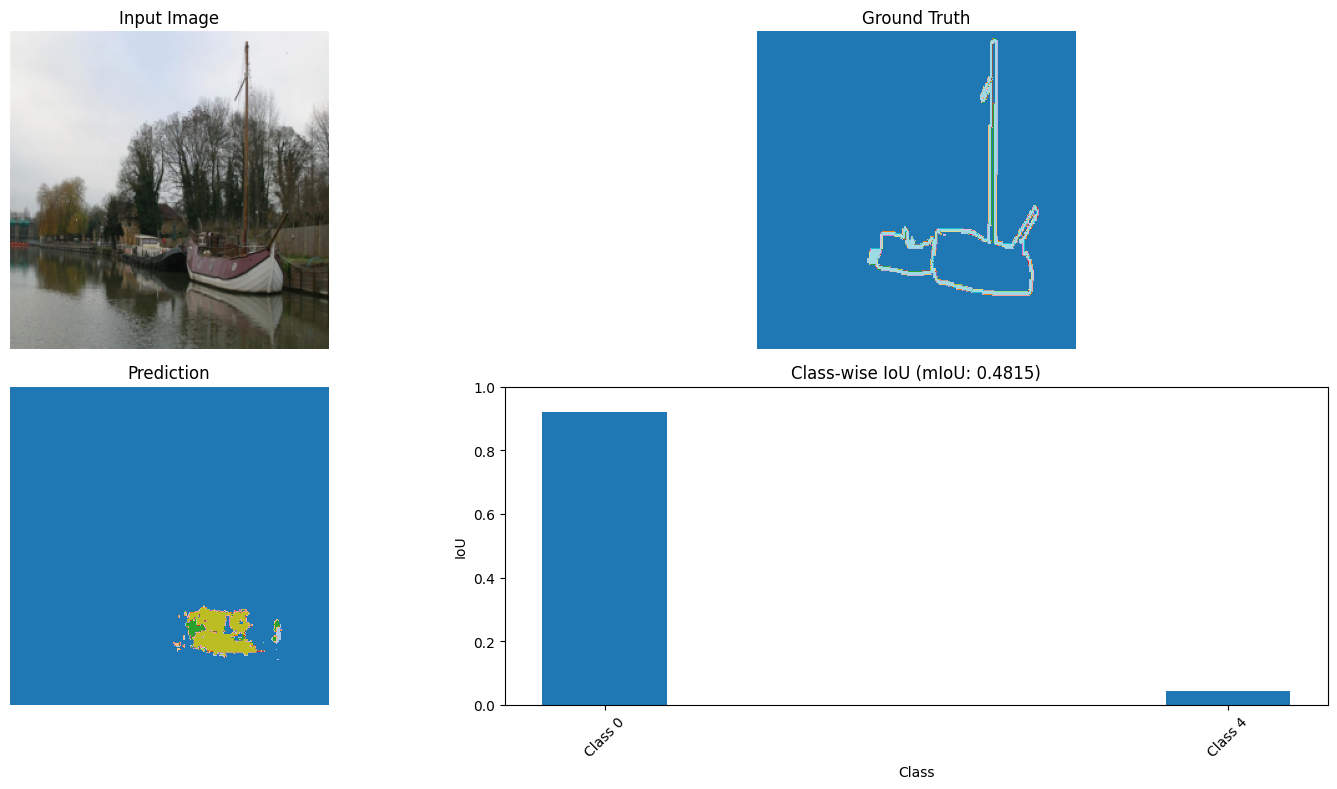

Index: 2, mIoU: 0.4815
Overall Average mIoU: 0.4824


In [13]:
from FinalModel import AdvancedSegmentationCNN
# Load your model
num_classes = 21  # VOCSegmentation has 21 classes
model = AdvancedSegmentationCNN(num_classes)
model.load_state_dict(torch.load("./KnowledgeDistillation/Cosine_student_model_TeacherBIAS1.0.pth"))
# model.load_state_dict(torch.load("HeavyAugment_segmentation_model_best_augmented1.pth"))
model = model.to(device)
model.eval()


# Example Usage
indices_to_visualize = [0,77,777,707,2]  # Indices to visualize
visualize_and_analyze(indices_to_visualize, visualize=True)

# Calculate and save all mIoUs to CSV
calculate_all_mious(csv_path="miou_all_samples.csv")